## Movie Genre Classification

Classify a movie genre based on its plot.

<img src="https://raw.githubusercontent.com/sergiomora03/AdvancedTopicsAnalytics/main/notebooks/img/moviegenre.png"
     style="float: left; margin-right: 10px;" />



### Data

Input:
- movie plot

Output:
Probability of the movie belong to each genre


### Evaluation

- 30% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 30% Code with the data processing and models developed that support the reported results.
- 30% Presentation of no more than 15 minutes with the main results of the project.
- 10% Model performance achieved. Metric: "AUC".

• The project must be carried out in groups of 4 people.
• Use clear and rigorous procedures.
• The delivery of the project is on March 15th, 2024, 11:59 pm, through email with Github link.
• No projects will be received after the delivery time or by any other means than the one established.




### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

## Cargue de datos y librerias

In [72]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer,MinMaxScaler ,label_binarize,StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split , RandomizedSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
import re
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
# Descargar las stopwords
nltk.download('stopwords')
# Obtener las stopwords en inglés
stop_words = set(stopwords.words('english'))
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten ,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import urllib.request
import warnings
import random
from tensorflow.keras.regularizers import l1_l2
#from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from gensim.models import Word2Vec

np.random.seed(4226)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RaulE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\RaulE\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RaulE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [3]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [4]:
dataTraining.describe

<bound method NDFrame.describe of       year                              title  \
3107  2003                               Most   
900   2008          How to Be a Serial Killer   
6724  1941                     A Woman's Face   
4704  1954                    Executive Suite   
2582  1990                      Narrow Margin   
...    ...                                ...   
8417  2010                 Our Family Wedding   
1592  1984                Conan the Destroyer   
1723  1955                             Kismet   
7605  1982                 The Secret of NIMH   
215   2009  Tinker Bell and the Lost Treasure   

                                                   plot  \
3107  most is the story of a single father who takes...   
900   a serial killer decides to teach the secrets o...   
6724  in sweden ,  a female blackmailer with a disfi...   
4704  in a friday afternoon in new york ,  the presi...   
2582  in los angeles ,  the editor of a publishing h...   
...                    

In [5]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


## Limpieza de datos

### Identificación de Stopwords

In [8]:
print(stop_words)

{'under', "you'd", 'their', 'the', "you'll", 'do', 'what', 'more', 'o', "don't", 'did', 'against', 'most', 'doing', 'me', "hadn't", 'few', 'myself', 'not', 'ma', 'them', 'over', "you're", 'in', 'hadn', 'is', 'it', 'wasn', 'how', 'should', 'an', 'can', 'will', 'from', 're', "couldn't", 'itself', 'was', 'out', 'these', 'll', 'each', "mustn't", 'have', 'haven', 'mustn', "wouldn't", "shan't", 'doesn', 'your', 'up', 'ourselves', "you've", "should've", "isn't", 'whom', "won't", 'him', 'are', "it's", 'you', 'wouldn', "didn't", 'during', 'mightn', 'once', 'yourself', "she's", 'than', 'just', 'her', 'while', 'his', 'but', 'which', 'both', 'to', 'some', 'same', 'our', 'shan', 'by', 'now', 'off', 'of', 'too', 'd', 'a', 'if', 'm', 'themselves', 'then', "that'll", "aren't", 'theirs', 'they', "hasn't", 'because', 'does', 'so', 'isn', "shouldn't", "wasn't", 'aren', 'that', 't', 'didn', 'don', 've', 'won', 'i', 'there', 'has', 'having', 'further', 'with', 'yours', 'above', 'he', 'about', 'why', 'weren

## Funciones necesarias para Limpieza y lematización

In [3]:
#Lematizacion 
lemmatizer = WordNetLemmatizer()
def tokenize_and_lemmatize(text):
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(lemmatized_tokens)

#Limpieza de texto
def limpiar_texto(DtaTraining):
    DtaTrainingLimpia = [
        ' '.join(word for word in re.sub(r"[.,;:!-]", '', doc.lower()).split())
        for doc in DtaTraining
    ]
    return DtaTrainingLimpia

## Creación vector y

In [15]:
print(dataTraining['genres'])

3107                                   ['Short', 'Drama']
900                         ['Comedy', 'Crime', 'Horror']
6724                   ['Drama', 'Film-Noir', 'Thriller']
4704                                            ['Drama']
2582                      ['Action', 'Crime', 'Thriller']
                              ...                        
8417                                ['Comedy', 'Romance']
1592                   ['Action', 'Adventure', 'Fantasy']
1723    ['Adventure', 'Musical', 'Fantasy', 'Comedy', ...
7605    ['Animation', 'Adventure', 'Drama', 'Family', ...
215       ['Animation', 'Adventure', 'Family', 'Fantasy']
Name: genres, Length: 7895, dtype: object


In [4]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

column_names_Y = le.classes_
print(column_names_Y)

['Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Family' 'Fantasy' 'Film-Noir' 'History' 'Horror'
 'Music' 'Musical' 'Mystery' 'News' 'Romance' 'Sci-Fi' 'Short' 'Sport'
 'Thriller' 'War' 'Western']


### BOW + Glove + RN Sencilla


In [21]:
DtaTraining = dataTraining['plot'] + ' ' + dataTraining['title']
DtaTrainingLimpia = limpiar_texto(DtaTraining)
DTraining_lematizado_token = [tokenize_and_lemmatize(doc) for doc in DtaTrainingLimpia]

In [22]:
import gensim.downloader as api
# Download embeddings (66MB, glove, trained on wikipedia)
glove_model = api.load("glove-wiki-gigaword-50")

In [23]:
# Crear una función para obtener el embedding promedio de GloVe
def get_average_embedding(text, model):
    embeddings = []
    for word in text.split():
        if word in model:
            embeddings.append(model[word])
    if len(embeddings) == 0:
        return np.zeros(model.vector_size)
    return np.mean(embeddings, axis=0)

# Vectorización sencilla con Bag of Words
count_vect = CountVectorizer()
bow_X = count_vect.fit_transform(DTraining_lematizado_token)

# Crear la matriz de embeddings de GloVe
glove_X = np.array([get_average_embedding(text, glove_model) for text in DTraining_lematizado_token])

# Combinar ambas representaciones Glove y BOW
combined_X = np.hstack((bow_X.toarray(), glove_X))

# Dividir los datos en conjuntos de entrenamiento y prueba
XBOW_train, XBOW_test, yBOW_train_genres, yBOW_test_genres = train_test_split(
    combined_X, y_genres, test_size=0.33, random_state=42)

# Verificar el tamaño de los conjuntos, que coincidan para no generar errores por diferencia en tamaños
print(XBOW_train.shape, yBOW_train_genres.shape)
print(XBOW_test.shape, yBOW_test_genres.shape)


(5289, 35477) (5289, 24)
(2606, 35477) (2606, 24)


In [24]:
def modelo_red2_keras(CE_x, CE_y, CV_x, CV_y, n_h, num_iter, tasa, dropout_rate, batch_size, semilla, print_c):
    np.random.seed(semilla)
    tf.random.set_seed(semilla)

    model = Sequential()
    model.add(Flatten(input_shape=CE_x.shape[1:]))
    
    # Capa oculta sin BatchNormalization
    model.add(Dense(units=n_h, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout ajustado o eliminado
    
    # Capa de salida
    model.add(Dense(CE_y.shape[1], activation='sigmoid'))
    
    # Optimización con Adam y tasa de aprendizaje ajustada
    model.compile(optimizer=Adam(learning_rate=tasa), loss='binary_crossentropy', metrics=['AUC'])

    # Callbacks: EarlyStopping y ReduceLROnPlateau para optimizar el entrenamiento
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    # Entrenamiento
    history = model.fit(CE_x, CE_y, validation_data=(CV_x, CV_y), 
                        batch_size=batch_size, epochs=num_iter, 
                        verbose=1 if print_c else 0, callbacks=[early_stopping, reduce_lr])

    param = model.get_weights()
    epoc = np.argmin(history.history['val_loss']) + 1
    return model, param, epoc, history

# Entrenar el modelo simplificado
model, param, epoc, history = modelo_red2_keras(
    XBOW_train, yBOW_train_genres, XBOW_test, yBOW_test_genres,
    n_h=400,  # número de neuronas ajustado en la capa oculta
    num_iter=100,  # número de épocas ajustado
    tasa=1e-4,  # tasa de aprendizaje ajustada
    dropout_rate=0.2,  # tasa de dropout ajustada
    batch_size=128,  # tamaño de batch ajustado
    semilla=42,
    print_c=True
)

# Evaluar el modelo
loss, auc = model.evaluate(XBOW_test, yBOW_test_genres)
print(f"Loss en validación: {loss}")
print(f"AUC en validación: {auc}")

C:\Users\RaulE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - AUC: 0.5407 - loss: 0.6470 - val_AUC: 0.6997 - val_loss: 0.4964 - learning_rate: 1.0000e-04
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - AUC: 0.7131 - loss: 0.4523 - val_AUC: 0.7266 - val_loss: 0.3677 - learning_rate: 1.0000e-04
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - AUC: 0.7572 - loss: 0.3448 - val_AUC: 0.7639 - val_loss: 0.3224 - learning_rate: 1.0000e-04
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - AUC: 0.8046 - loss: 0.3010 - val_AUC: 0.7938 - val_loss: 0.3011 - learning_rate: 1.0000e-04
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - AUC: 0.8426 - loss: 0.2745 - val_AUC: 0.8168 - val_loss: 0.2862 - learning_rate: 1.0000e-04
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - AUC: 0.8746 - loss: 0.2517 - val_AUC: 0.8352 - val_loss: 0.2738 - learning_rate: 1.0000e-04
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - AUC: 0.9008 - loss: 0.2317 - val_AUC: 0.8506 - val_loss: 0.2631 - lea

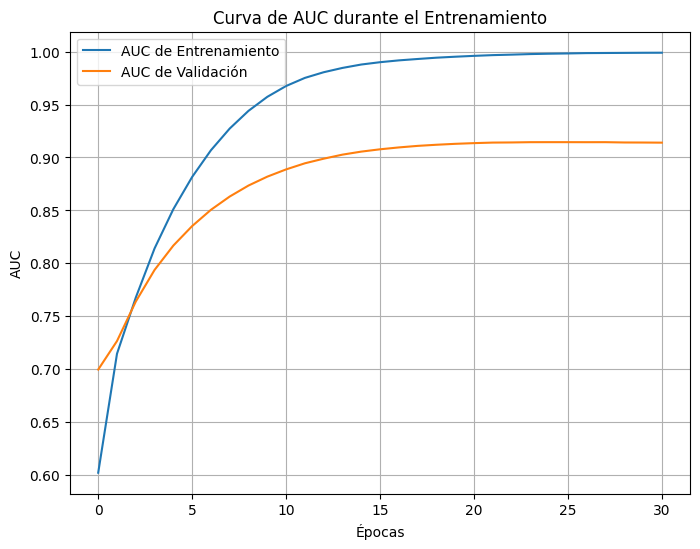

In [26]:
# Gráfico de AUC
plt.figure(figsize=(8, 6))
plt.plot(history.history['AUC'], label='AUC de Entrenamiento')
plt.plot(history.history['val_AUC'], label='AUC de Validación')
plt.title('Curva de AUC durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()
plt.grid()
plt.show()

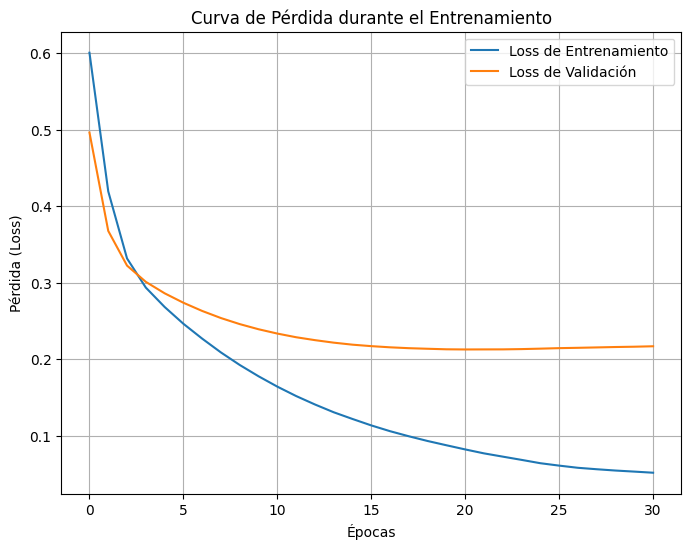

In [27]:
# Graficar Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss de Entrenamiento')
plt.plot(history.history['val_loss'], label='Loss de Validación')
plt.title('Curva de Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()
plt.grid()
plt.show()

In [31]:
# Obtener las predicciones del modelo (probabilidades)
y_pred_prob = model.predict(XBOW_test)

# Convertir las probabilidades a clases (umbral = 0.6)
y_pred_classes = (y_pred_prob >= 0.6).astype(int)

# Calcular la exhaustividad
exhaustividad = recall_score(yBOW_test_genres, y_pred_classes, average='macro')
accuracy = accuracy_score(yBOW_test_genres, y_pred_classes)
precision = precision_score(yBOW_test_genres, y_pred_classes, average='weighted')

print(f"Precisión del modelo: {precision:.2f}")
#print(f"Exhaustividad (Recall) del modelo: {exhaustividad:.2f}")
#print(f"Accuracy (Recall) del modelo: {accuracy:.2f}")


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Precisión del modelo: 0.75


C:\Users\RaulE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validacion del mejor modelo : BOW + Glove + RN Sencilla

In [ ]:
nuevas_peliculas = [
    {"title": "The World According to Sesame Street", "plot": "A documentary which examines the creation and co-production of the popular children’s television program in three developing countries: bangladesh , kosovo and south africa ."},
    {"title": "Babar: the movie", "plot": "In his spectacular film debut , young babar , king of the elephants , must save his homeland from certain destruction by rataxes and his band of invading rhinos ."},
    {"title": "Batman", "plot": "gotham city :  dark ,  dangerous ,   ' protected '  only by a mostly corrupt police department .  despite the best efforts of d . a .  harvey dent and police commissioner jim gordon ,  the city becomes increasingly unsafe .  .  . until a dark knight arises .  we all know criminals are a superstitious ,  cowardly lot .  .  . so his disguise must be able to strike terror into their hearts .  he becomes a bat .  enter vicky vale ,  a prize - winning photo journalist who wants to uncover the secret of the mysterious  bat - man  .  and enter jack napier ,  one - time enforcer for boss grissom ,  horribly disfigured after a firefight in a chemical factory .  .  . who ,  devoid of the last vestiges of sanity ,  seizes control of gotham ' s underworld as the psychotic ,  unpredictable clown prince of crime .  .  . the joker .  gotham ' s only hope ,  it seems ,  lies in this dark ,  brooding vigilante .  and just how does billionaire playboy bruce wayne fit into all of this ?"},
    {"title": "Toy Story", "plot": "a little boy named andy loves to be in his room ,  playing with his toys ,  especially his doll named  woody  .  but ,  what do the toys do when andy is not with them ,  they come to life .  woody believes that he has life  ( as a toy )  good .  however ,  he must worry about andy ' s family moving ,  and what woody does not know is about andy ' s birthday party .  woody does not realize that andy ' s mother gave him an action figure known as buzz lightyear ,  who does not believe that he is a toy ,  and quickly becomes andy ' s new favorite toy .  woody ,  who is now consumed with jealousy ,  tries to get rid of buzz .  then ,  both woody and buzz are now lost .  they must find a way to get back to andy before he moves without them ,  but they will have to pass through a ruthless toy killer ,  sid phillips ."},
]

nuevas_descripciones = [f"{pelicula['plot']} {pelicula['title']}" for pelicula in nuevas_peliculas]

# Limpieza
nuevas_descripciones_limpias = [
    ' '.join(word for word in re.sub(r"[.,;:!-]", '', doc.lower()).split())
    for doc in nuevas_descripciones
]

# Lematización
nuevas_descripciones_lemmatizadas = [tokenize_and_lemmatize(doc) for doc in nuevas_descripciones_limpias]

# Vectorización BoW
bow_nuevas = count_vect.transform(nuevas_descripciones_lemmatizadas)

# Crear la matriz de embeddings de GloVe
glove_nuevas = np.array([get_average_embedding(text, glove_model) for text in nuevas_descripciones_lemmatizadas])

# Combinar ambas representaciones BoW y GloVe
combined_nuevas = np.hstack((bow_nuevas.toarray(), glove_nuevas))

# Hacer predicciones
predicciones = model.predict(combined_nuevas)

# Convertir predicciones a etiquetas de géneros
predicciones_genres = (predicciones > 0.3).astype(int)  # Umbral de 0.5 para clasificación binaria

# Obtener nombres de géneros
predicciones_nombres = le.inverse_transform(predicciones_genres)

# Mostrar resultados
for i, pelicula in enumerate(nuevas_peliculas):
    print(f"Título: {pelicula['title']}, Predicciones de géneros: {predicciones_nombres[i]}")


### Regresión Logística / Random Forest + Usando Variable Year

In [5]:
DtaTraining = dataTraining['plot'] + ' ' + dataTraining['title']
DtaTrainingLimpia = limpiar_texto(DtaTraining)
DTraining_lematizado_token = [tokenize_and_lemmatize(doc) for doc in DtaTrainingLimpia]

In [6]:
vectNgramas = CountVectorizer(ngram_range=(1, 3))
X_dtm = vectNgramas.fit_transform(DTraining_lematizado_token)
X_dtm.shape

(7895, 997903)

In [7]:
# Prepare 'year' feature
scaler = MinMaxScaler()
X_year = scaler.fit_transform(dataTraining[['year']])

In [8]:
X_train, X_test,X_train_year, X_test_year, y_train_genres, y_test_genres = train_test_split(X_dtm,X_year, y_genres, test_size=0.33, random_state=42)

In [9]:
# Combine features
X_train_combined = hstack([X_train, X_train_year])
X_test_combined = hstack([X_test, X_test_year])

In [10]:
# Classifier with adjusted parameters
clf = OneVsRestClassifier(LogisticRegression(C=1.0, solver='lbfgs', max_iter=2000))

# Train the classifier
clf.fit(X_train_combined, y_train_genres)


OneVsRestClassifier(estimator=LogisticRegression(max_iter=2000))

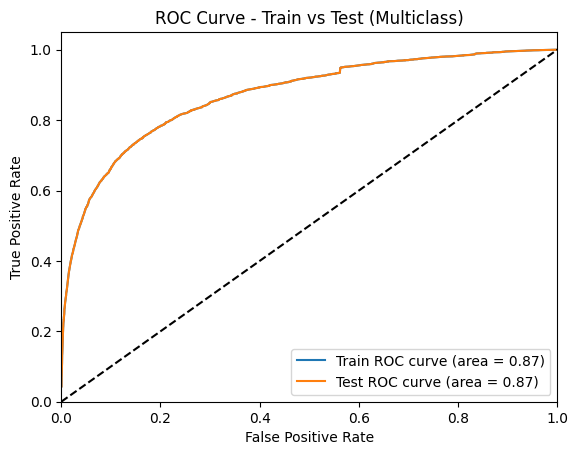

In [17]:
# Obtener probabilidades
y_score_train = clf.predict_proba(X_train_combined)
y_score_test = clf.predict_proba(X_test_combined)

n_classes = y_train_genres.shape[1]

# Inicializar variables para ROC promedio
fpr = dict()
tpr = dict()
roc_auc_train = dict()
roc_auc_test = dict()

# Calcular curvas ROC por clase en train y test
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_genres[:, i], y_score_train[:, i])
    roc_auc_train[i] = auc(fpr[i], tpr[i])
    
    fpr[i], tpr[i], _ = roc_curve(y_test_genres[:, i], y_score_test[:, i])
    roc_auc_test[i] = auc(fpr[i], tpr[i])

# Calcular promedio macro para ROC en train y test
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr_train = np.zeros_like(all_fpr)
mean_tpr_test = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr_train += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr_test += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr_train /= n_classes
mean_tpr_test /= n_classes

# Calcular el AUC promedio
roc_auc_mean_train = auc(all_fpr, mean_tpr_train)
roc_auc_mean_test = auc(all_fpr, mean_tpr_test)

# Graficar curvas ROC promedio para train y test
plt.figure()
plt.plot(all_fpr, mean_tpr_train, label=f'Train ROC curve (area = {roc_auc_mean_train:.2f})')
plt.plot(all_fpr, mean_tpr_test, label=f'Test ROC curve (area = {roc_auc_mean_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Train vs Test (Multiclass)')
plt.legend(loc='lower right')
plt.show()

Cambiando la regresión por un RF pero Usando las mismas Columnas

In [18]:
# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42,
                                   scoring='roc_auc_ovo')

# Entrenar con los mejores parámetros
random_search.fit(X_train_combined, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test_combined)
# Acceder a las probabilidades de la clase positiva (segunda columna)
y_pred_genres_optimized = random_search.predict_proba(X_test_combined)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))
# Obtener los mejores parámetros
best_params = random_search.best_params_
print("Mejores parámetros encontrados por RandomizedSearchCV:")
print(best_params)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.8766964324775722
Mejores parámetros encontrados por RandomizedSearchCV:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 30, 'bootstrap': False}


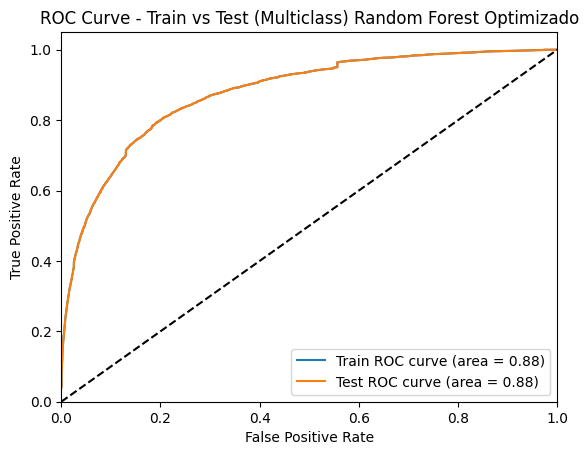

AUC promedio para el conjunto de entrenamiento: 0.88
AUC promedio para el conjunto de prueba: 0.88


In [19]:
# Calcular las probabilidades de las clases para el conjunto de prueba
y_score_train = random_search.predict_proba(X_train_combined)
y_score_test = random_search.predict_proba(X_test_combined)

n_classes = y_train_genres.shape[1]

# Inicializar variables para ROC promedio
fpr = dict()
tpr = dict()
roc_auc_train = dict()
roc_auc_test = dict()

# Calcular curva ROC para cada clase en train y test
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_genres[:, i], y_score_train[i][:, 1])
    roc_auc_train[i] = auc(fpr[i], tpr[i])
    
    fpr[i], tpr[i], _ = roc_curve(y_test_genres[:, i], y_score_test[i][:, 1])
    roc_auc_test[i] = auc(fpr[i], tpr[i])

# Calcular promedio macro para ROC en train y test
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr_train = np.zeros_like(all_fpr)
mean_tpr_test = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr_train += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr_test += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr_train /= n_classes
mean_tpr_test /= n_classes

# Calcular el AUC promedio
roc_auc_mean_train = auc(all_fpr, mean_tpr_train)
roc_auc_mean_test = auc(all_fpr, mean_tpr_test)

# Graficar curvas ROC promedio para train y test
plt.figure()
plt.plot(all_fpr, mean_tpr_train, label=f'Train ROC curve (area = {roc_auc_mean_train:.2f})')
plt.plot(all_fpr, mean_tpr_test, label=f'Test ROC curve (area = {roc_auc_mean_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Train vs Test (Multiclass) Random Forest Optimizado')
plt.legend(loc='lower right')
plt.show()

# Imprimir el AUC promedio para referencia
print(f"AUC promedio para el conjunto de entrenamiento: {roc_auc_mean_train:.2f}")
print(f"AUC promedio para el conjunto de prueba: {roc_auc_mean_test:.2f}")

### N-Grams (1-3) con ajuste de max feautres & Random Forest


In [32]:
DtaTraining = dataTraining['plot']
DtaTrainingLimpia = limpiar_texto(DtaTraining)
DTraining_lematizado_token = [tokenize_and_lemmatize(doc) for doc in DtaTrainingLimpia]

In [33]:
vectNgramas = CountVectorizer(ngram_range=(1, 3),max_features=900000)
X_dtm = vectNgramas.fit_transform(DTraining_lematizado_token)
X_dtm.shape

(7895, 900000)

In [34]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [35]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42)

# Entrenar con los mejores parámetros
random_search.fit(X_train, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test)
# Acceder a las probabilidades de la clase positiva (segunda columna)
y_pred_genres_optimized = random_search.predict_proba(X_test)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))
# Obtener los mejores parámetros
best_params = random_search.best_params_
print("Mejores parámetros encontrados por RandomizedSearchCV:")
print(best_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.8744663437889036


### BOW & Red Neuronal Sencilla

In [45]:
DtaTraining = dataTraining['plot']
DtaTrainingLimpia = limpiar_texto(DtaTraining)
DTraining_lematizado_token = [tokenize_and_lemmatize(doc) for doc in DtaTrainingLimpia]

In [46]:
count_vect = CountVectorizer()
#Build a BOW representation for the corpus
bow_X = count_vect.fit_transform(DTraining_lematizado_token)

print("Our vocabulary: ", count_vect.vocabulary_)  

Our vocabulary:  {'story': 29453, 'single': 28071, 'father': 11003, 'take': 30274, 'eight': 9609, 'year': 34185, 'old': 21745, 'son': 28624, 'work': 33995, 'railroad': 24728, 'drawbridge': 9119, 'bridge': 3770, 'tender': 30574, 'day': 7507, 'boy': 3579, 'meet': 19561, 'woman': 33934, 'boarding': 3275, 'train': 31332, 'drug': 9211, 'abuser': 115, 'go': 12754, 'engine': 9995, 'room': 26341, 'tell': 30536, 'stay': 29232, 'edge': 9529, 'nearby': 20979, 'lake': 17291, 'ship': 27772, 'come': 5890, 'lifted': 17885, 'though': 30832, 'supposed': 29917, 'arrive': 1517, 'hour': 14599, 'later': 17445, 'happens': 13636, 'see': 27316, 'try': 31664, 'warn': 33305, 'able': 55, 'oncoming': 21802, 'approach': 1322, 'fall': 10859, 'gear': 12394, 'attempting': 1774, 'lower': 18342, 'leaving': 17594, 'horrific': 14536, 'choice': 5248, 'crushing': 7086, 'people': 22837, 'completely': 6028, 'oblivious': 21584, 'fact': 10786, 'died': 8321, 'trying': 31665, 'save': 26894, 'addict': 295, 'happened': 13634, 'loo

In [47]:
XBOW_train, XBOW_test, yBOW_train_genres, yBOW_test_genres = train_test_split(
    bow_X, y_genres, test_size=0.33, random_state=42)

# Verificar el tamaño de los conjuntos
print(XBOW_train.shape, yBOW_train_genres.shape)  # Deben tener la misma cantidad de muestras
print(XBOW_test.shape, yBOW_test_genres.shape)

(5289, 34461) (5289, 24)
(2606, 34461) (2606, 24)


In [48]:
def modelo_red2_keras(CE_x, CE_y, CV_x, CV_y, n_h, num_iter, tasa, dropout_rate, batch_size, semilla, print_c):
    np.random.seed(semilla)
    tf.random.set_seed(semilla)

    model = Sequential()    
    model.add(Flatten(input_shape=CE_x.shape[1:]))
    model.add(Dense(units=n_h, activation='relu'))
    model.add(Dropout(dropout_rate))
    # Ajustar la salida para multilabel
    model.add(Dense(CE_y.shape[1], activation='sigmoid'))  # Número de salidas igual al número de etiquetas
    # Usar binary_crossentropy para multilabel
    model.compile(optimizer=Adam(learning_rate=tasa), loss='binary_crossentropy', metrics=['AUC'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    history = model.fit(CE_x, CE_y, validation_data=(CV_x, CV_y), batch_size=batch_size, epochs=num_iter, verbose=1 if print_c else 0, callbacks=[early_stopping])
    
    param = model.get_weights()
    epoc = np.argmin(history.history['val_loss']) + 1  # Mejor época basada en validación
    return model, param, epoc, history

In [49]:
# Convertir las matrices dispersas en matrices densas
XBOW_train_dense = XBOW_train.toarray()
XBOW_test_dense = XBOW_test.toarray()

# Entrenar el modelo con las matrices densas
model, param, epoc, history = modelo_red2_keras(
    XBOW_train_dense, yBOW_train_genres, XBOW_test_dense, yBOW_test_genres,
    n_h=428,  # número de neuronas en la capa oculta
    num_iter=163,  # número de épocas
    tasa=3.9563664553994944e-05,  # tasa de aprendizaje
    dropout_rate=0.2948388655655226,  # tasa de dropout
    batch_size=325,  # tamaño de batch
    semilla=42,
    print_c=True
)

C:\Users\RaulE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - AUC: 0.5251 - loss: 0.6845 - val_AUC: 0.6151 - val_loss: 0.6629
Epoch 2/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - AUC: 0.6376 - loss: 0.6543 - val_AUC: 0.6704 - val_loss: 0.6337
Epoch 3/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - AUC: 0.6888 - loss: 0.6234 - val_AUC: 0.6885 - val_loss: 0.6020
Epoch 4/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - AUC: 0.7096 - loss: 0.5899 - val_AUC: 0.6933 - val_loss: 0.5686
Epoch 5/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - AUC: 0.7154 - loss: 0.5552 - val_AUC: 0.6942 - val_loss: 0.5358
Epoch 6/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - AUC: 0.7208 - loss: 0.5216 - val_AUC: 0.6949 - val_loss: 0.5053
Epoch 7/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - AUC: 0.7252 - loss: 0.4908 - val_AUC: 0.6967 - val_loss: 0.4780
Epoch 8/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - AUC: 0.7290 - loss: 0.4635 - val_AUC: 0.6995 - val_loss: 0.4543
Epoch 9/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/

In [50]:
# Evaluación del modelo en conjunto de validación
loss, auc = model.evaluate(XBOW_test_dense, yBOW_test_genres)
print(f"Loss en validación: {loss}")
print(f"AUC en validación: {auc}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8761 - loss: 0.2439
Loss en validación: 0.24582694470882416
AUC en validación: 0.8712891936302185


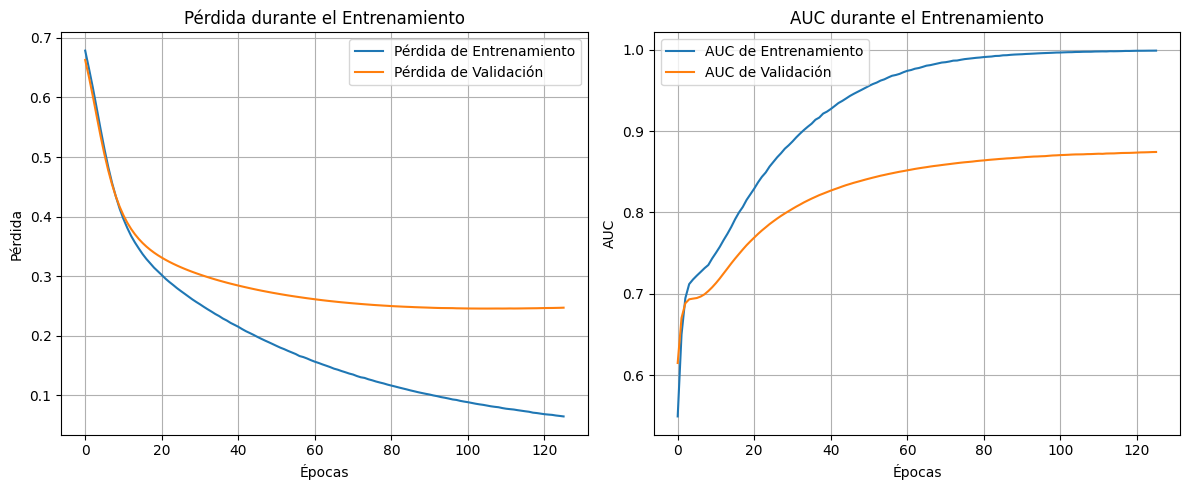

In [54]:
# Gráfico de pérdida (loss)
plt.figure(figsize=(12, 5))

# Gráfico de loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()

# Gráfico de AUC
plt.subplot(1, 2, 2)
plt.plot(history.history['AUC'], label='AUC de Entrenamiento')
plt.plot(history.history['val_AUC'], label='AUC de Validación')
plt.title('AUC durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()
plt.grid()

# Mostrar los gráficos
plt.tight_layout()
plt.show()



### N-Grams (1-3) con ajuste de min_df & Random Forest


In [55]:
DtaTraining = dataTraining['plot']
DtaTrainingLimpia = limpiar_texto(DtaTraining)
DTraining_lematizado_token = [tokenize_and_lemmatize(doc) for doc in DtaTrainingLimpia]

In [56]:
vectNgramas = CountVectorizer(ngram_range=(1, 3),min_df=2)
X_dtm = vectNgramas.fit_transform(DTraining_lematizado_token)
X_dtm.shape

(7895, 63577)

In [57]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [58]:
# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42)

# Entrenar con los mejores parámetros
random_search.fit(X_train, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test)
# Acceder a las probabilidades de la clase positiva (segunda columna)
y_pred_genres_optimized = random_search.predict_proba(X_test)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))
best_params = random_search.best_params_
print("Mejores parámetros encontrados por RandomizedSearchCV:")
print(best_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.8566481094218504


### N-grams (1- 4) & Random Forest

In [59]:
DtaTraining = dataTraining['plot']
DtaTrainingLimpia = limpiar_texto(DtaTraining)
DTraining_lematizado_token = [tokenize_and_lemmatize(doc) for doc in DtaTrainingLimpia]

In [60]:
vectNgramas = CountVectorizer(ngram_range=(1, 4))
X_dtm = vectNgramas.fit_transform(DTraining_lematizado_token)
X_dtm.shape

(7895, 1481576)

In [61]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [62]:
# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42)

# Entrenar con los mejores parámetros
random_search.fit(X_train, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test)
# Acceder a las probabilidades de la clase positiva (segunda columna)
y_pred_genres_optimized = random_search.predict_proba(X_test)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))
best_params = random_search.best_params_
print("Mejores parámetros encontrados por RandomizedSearchCV:")
print(best_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.843708257051456
Mejores parámetros encontrados por RandomizedSearchCV:
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}


### TF-IDF & Random Forest

In [64]:
DtaTraining = dataTraining['plot']
DtaTrainingLimpia = limpiar_texto(DtaTraining)
DTraining_lematizado_token = [tokenize_and_lemmatize(doc) for doc in DtaTrainingLimpia]

tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(DTraining_lematizado_token)

# Repartir los datos de nuevo con las nuevas características
XTFIDF_train, XTFIDF_test, yTFIDF_train_genres, yTFIDF_test_genres = train_test_split(X_tfidf, y_genres, test_size=0.33, random_state=42)

# Entrenar el modelo con TF-IDF
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(XTFIDF_train, yTFIDF_train_genres)

yTFIDF_pred_genres = clf.predict_proba(XTFIDF_test)

roc_auc_tfidf = roc_auc_score(yTFIDF_test_genres, yTFIDF_pred_genres, average='macro')
print(f"AUC con TF-IDF: {roc_auc_tfidf}")


AUC con TF-IDF: 0.8094747961022325


### Word2Vec

In [67]:
DtaTraining = dataTraining['plot']
DtaTrainingLimpia = limpiar_texto(DtaTraining)
DTraining_lematizado_token = [tokenize_and_lemmatize(doc) for doc in DtaTrainingLimpia]

# Entrenar el modelo Word2Vec con 1000 dimensiones
word2vec = Word2Vec(sentences=DTraining_lematizado_token,   vector_size=1000, window=3, min_count=1, workers=4)

# Crear los vectores promedio para cada documento
X_word2vec = np.array([np.mean([word2vec.wv[word] for word in words if word in word2vec.wv] or [np.zeros(1000)], axis=0)
                       for words in DTraining_lematizado_token])

print(X_word2vec.shape)  # Verifica la forma del resultado


(7895, 1000)


In [68]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_word2vec, y_genres, test_size=0.33, random_state=42)

In [69]:
# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42)

# Entrenar con los mejores parámetros
random_search.fit(X_train, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test)
# Acceder a las probabilidades de la clase positiva (segunda columna)
y_pred_genres_optimized = random_search.predict_proba(X_test)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.6149365527435561


### Word2Vec & Random Forest

In [73]:
DtaTraining = dataTraining['plot']
DtaTrainingLimpia = limpiar_texto(DtaTraining)
DTraining_lematizado_token = [tokenize_and_lemmatize(doc) for doc in DtaTrainingLimpia]

word2vec = Word2Vec(sentences=DTraining_lematizado_token, vector_size=100, window=5, min_count=1, workers=4)
X_word2vec = np.array([np.mean([word2vec.wv[word] for word in words if word in word2vec.wv] or [np.zeros(100)], axis=0)
                       for words in DTraining_lematizado_token])

# Escalar los datos
scaler = StandardScaler()
X_word2vec_scaled = scaler.fit_transform(X_word2vec)

# División de los datos
X_trainW2V, X_testW2V, y_trainW2V_genres, y_testW2V_genres = train_test_split(X_word2vec_scaled, y_genres, test_size=0.33, random_state=42)

# Entrenar el modelo
clf_w2v = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf_w2v.fit(X_trainW2V, y_trainW2V_genres)

y_pred_genres_w2v = clf_w2v.predict_proba(X_testW2V)

roc_auc_w2v = roc_auc_score(y_testW2V_genres, y_pred_genres_w2v, average='macro')
print(f"AUC con Word2Vec: {roc_auc_w2v}")

AUC con Word2Vec: 0.5935295466788676


### TF-IDF + Word2Vec & Random Forest

In [74]:
DtaTraining = dataTraining['plot']
DtaTrainingLimpia = limpiar_texto(DtaTraining)
DTraining_lematizado_token = [tokenize_and_lemmatize(doc) for doc in DtaTrainingLimpia]

# 1. Crear la matriz TF-IDF
tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(DTraining_lematizado_token)

# 2. Repartir los datos
XTFIDF_W2V_train, XTFIDF_W2V_test, yTFIDF_W2V_train_genres, yTFIDF_W2V_test_genres = train_test_split(X_tfidf, y_genres, test_size=0.33, random_state=42)

# 3. Entrenar el modelo con TF-IDF
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(XTFIDF_W2V_train, yTFIDF_W2V_train_genres)

yTFIDF_W2V_pred_genres = clf.predict_proba(XTFIDF_W2V_test)

# 4. Calcular AUC con TF-IDF
roc_auc_tfidf = roc_auc_score(yTFIDF_W2V_test_genres, yTFIDF_W2V_pred_genres, average='macro')
print(f"AUC con TF-IDF: {roc_auc_tfidf}")

# 5. Entrenar el modelo Word2Vec
model_w2v = Word2Vec(sentences=DTraining_lematizado_token, vector_size=100, window=10, min_count=1, workers=4)

# 6. Función para obtener vectores promedio ponderados usando Word2Vec
def get_weighted_average_vector(doc, model, tfidf_vectorizer):
    words = doc.split()
    tfidf_weights = tfidf_vectorizer.transform([doc]).toarray()[0]
    word_vectors = np.array([model.wv[word] for word in words if word in model.wv])

    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)  # Retornar un vector nulo si no hay palabras

    valid_weights = np.array([tfidf_weights[i] for i, word in enumerate(words) if word in model.wv])
    # Verificar si hay pesos válidos
    if np.sum(valid_weights) == 0:
        return np.zeros(model.vector_size)  # Retornar un vector nulo si todos los pesos son cero

    weighted_avg_vector = np.average(word_vectors, axis=0, weights=valid_weights)
    return weighted_avg_vector

# 7. Calcular el vector promedio ponderado para cada documento
document_vectors_train = np.array([get_weighted_average_vector(doc, model_w2v, tfidf) for doc in DTraining_lematizado_token])

# 8. Repartir los datos utilizando los vectores de Word2Vec
X_w2v_train, X_w2v_test, y_w2v_train_genres, y_w2v_test_genres = train_test_split(document_vectors_train, y_genres, test_size=0.33, random_state=42)

# 9. Entrenar el modelo con Word2Vec
clf_w2v = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf_w2v.fit(X_w2v_train, y_w2v_train_genres)

# 10. Predecir y calcular AUC para Word2Vec
y_w2v_pred_genres = clf_w2v.predict_proba(X_w2v_test)
roc_auc_w2v = roc_auc_score(y_w2v_test_genres, y_w2v_pred_genres, average='macro')
print(f"AUC con Word2Vec: {roc_auc_w2v}")

AUC con TF-IDF: 0.8094747961022325
AUC con Word2Vec: 0.5020136023879113
